### Background and Rationale
Zuclopenthixol is an antipsychotic used for schizophrenia and other types psychoses. In the UK, there are two injecatable forms available
 - Zuclopenthixol **acetate** : a short acting treatment used for acute episodes 
 - Zuclopenthixol **decanoate** : a long acting treatment used for maintenance
 
 The [BNF has a safety warning](https://bnf.nice.org.uk/drug/zuclopenthixol-acetate.html) on both medicines advising that **acetate** preparartions are used in hospitals in acute episodes while **deconate** preparations are used in the community. The implcation being that **acetate** should not be prescribed in primary care. The East London Foundation Trusts Medication safety team have a [YouTube video](https://www.youtube.com/watch?v=Fac0QjO8J_Y&list=PLeEBLpkk4vtPZZFhJ0bWw79VwmRf39J97&index=1) discussing some of the issues with **acetate** and you can see similarities in the prouct packs.
 
 Initial analysis of the Analyse page reports [30,398 items for **Decanoate**](https://openprescribing.net/analyse/#org=CCG&numIds=0402020Z0&denom=nothing&selectedTab=summary) and [61 items for **acetate**](https://openprescribing.net/analyse/#org=CCG&numIds=040201010&denom=total_list_size&selectedTab=summary) in the last 12 months (current on July 19 data - click links to get latest data). 
 
 We propose a new measure to support a new type of alert that identifies outlier prescribing. It will identify any **acetate** prescribing for further investigation. 

### Proposed Measure

**Title**: Zuclopenthixol **acetate** prescribing

**Description**: Number of items for zuclopenthixol **actetate** items as a proprotion of all injectable zuclopenthixol items

**Why it matters**: The [BNF has a safety warning](https://bnf.nice.org.uk/drug/zuclopenthixol-acetate.html) advising that zuclopenthixol **acetate** should only be used in hospitals as it is a relatively short acting antipsychotic, supporting rapid tranquilisation. Sometimes it may be confused with zuclopnethixol **decanoate** a long acting antipsychotic which is more commonly prescribed in primary care supporting long term maintenance.

Any prescribing on this measure could prompt investigation to ascertain if zuclopenthixol was prescribed in error. <strong>Please note that this is an experimental measure to support a new type of alert</strong>. We would be grateful for any feedback at <a href='mailto:hello@ebmdatalab.net'>hello@ebmdatalab.net.</a> and you can read more about the measure in our Zuclopenthixol <a href='https://docs.google.com/document/d/1BaiDA2vyRk9EnnLoRm4mPt1etSk8ianwSuPcy3hE6cc/edit'>blog.</a>


In [1]:
#import libraries required for analysis
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps
import matplotlib.gridspec as gridspec

In [2]:
sql = """
WITH
bnf_tab AS (
SELECT
DISTINCT chemical,
chemical_code
FROM
ebmdatalab.hscic.bnf )
SELECT
rx.month,
rx.practice,
rx.pct,
SUBSTR(rx.bnf_code,1,9) AS chemical_code,
chemical,
sum(IF(rx.bnf_code LIKE "040201010%", items,0)) AS acetate,
sum(IF(rx.bnf_code LIKE "0402020Z0%", items,0)) AS decanoate,
sum(items) AS total_zuclo,
sum(actual_cost) as total_cost
FROM
hscic.normalised_prescribing_standard AS rx
LEFT JOIN
bnf_tab
ON
chemical_code =SUBSTR(rx.bnf_code,1,9)
JOIN
hscic.practices AS prac
ON
rx.practice = prac.code 
JOIN
  hscic.ccgs AS ccgs
ON
rx.pct=ccgs.code
WHERE
  prac.setting = 4
  AND (bnf_code LIKE "040201010%" OR ##acetate
  bnf_code LIKE "0402020Z0%") ##Decanoate
  AND
ccgs.org_type='CCG'
GROUP BY
rx.month,
rx.practice,
rx.pct,
chemical_code,
chemical
ORDER BY
month"""

df_zuclo = bq.cached_read(sql, csv_path='zuclo.csv')
df_zuclo['month'] = df_zuclo['month'].astype('datetime64[ns]')
df_zuclo.head(3)

,month,practice,pct,chemical_code,chemical,acetate,decanoate,total_zuclo,total_cost
0,2010-08-01,P88028,01W,0402020Z0,Zuclopenthixol Decanoate,0,1,1,33.56
1,2010-08-01,K83030,04G,0402020Z0,Zuclopenthixol Decanoate,0,1,1,16.80
2,2010-08-01,C88032,03N,0402020Z0,Zuclopenthixol Decanoate,0,1,1,16.80


In [3]:
df_zuclo["chemical"].unique()

array(['Zuclopenthixol Decanoate', 'Zuclopenthixol Acetate'], dtype=object)

In [4]:
df_decan = df_zuclo.loc[df_zuclo["chemical"] == "Zuclopenthixol Decanoate"]
df_decan.head()

,month,practice,pct,chemical_code,chemical,acetate,decanoate,total_zuclo,total_cost
0,2010-08-01,P88028,01W,0402020Z0,Zuclopenthixol Decanoate,0,1,1,33.56
1,2010-08-01,K83030,04G,0402020Z0,Zuclopenthixol Decanoate,0,1,1,16.80
2,2010-08-01,C88032,03N,0402020Z0,Zuclopenthixol Decanoate,0,1,1,16.80
3,2010-08-01,F81037,06T,0402020Z0,Zuclopenthixol Decanoate,0,12,12,118.26
4,2010-08-01,L84008,11M,0402020Z0,Zuclopenthixol Decanoate,0,2,2,3.66


In [5]:
df_acetate = df_zuclo.loc[df_zuclo["chemical"] == "Zuclopenthixol Acetate"]
df_acetate.head()

,month,practice,pct,chemical_code,chemical,acetate,decanoate,total_zuclo,total_cost
26,2010-08-01,F84111,08M,040201010,Zuclopenthixol Acetate,1,0,1,13.55
86,2010-08-01,G83018,07N,040201010,Zuclopenthixol Acetate,1,0,1,10.01
126,2010-08-01,F81100,06Q,040201010,Zuclopenthixol Acetate,1,0,1,13.52
154,2010-08-01,F81087,06Q,040201010,Zuclopenthixol Acetate,1,0,1,2.00
155,2010-08-01,C83045,03T,040201010,Zuclopenthixol Acetate,1,0,1,2.74


In [6]:
df_acetate_measure = df_zuclo.copy()

df_acetate_measure["measure_value"] = 100*(df_zuclo.acetate / df_zuclo.total_zuclo).fillna(0)
df_acetate_measure.head()

,month,practice,pct,chemical_code,chemical,acetate,decanoate,total_zuclo,total_cost,measure_value
0,2010-08-01,P88028,01W,0402020Z0,Zuclopenthixol Decanoate,0,1,1,33.56,0.0
1,2010-08-01,K83030,04G,0402020Z0,Zuclopenthixol Decanoate,0,1,1,16.80,0.0
2,2010-08-01,C88032,03N,0402020Z0,Zuclopenthixol Decanoate,0,1,1,16.80,0.0
3,2010-08-01,F81037,06T,0402020Z0,Zuclopenthixol Decanoate,0,12,12,118.26,0.0
4,2010-08-01,L84008,11M,0402020Z0,Zuclopenthixol Decanoate,0,2,2,3.66,0.0


In [7]:
ccg_acetate_measure = df_acetate_measure.groupby(["pct", "month"], as_index=False).sum()
ccg_acetate_measure.head()

,pct,month,acetate,decanoate,total_zuclo,total_cost,measure_value
0,00C,2010-08-01,1,1,2,28.31,100.0
1,00C,2010-09-01,0,2,2,36.60,0.0
2,00C,2010-10-01,1,2,3,50.13,100.0
3,00C,2010-11-01,0,4,4,66.85,0.0
4,00C,2010-12-01,0,3,3,54.93,0.0


In [8]:
ccg_acetate_measure["measure_value"] = (ccg_acetate_measure["acetate"] / ccg_acetate_measure["total_zuclo"])*100
ccg_acetate_measure.head()

,pct,month,acetate,decanoate,total_zuclo,total_cost,measure_value
0,00C,2010-08-01,1,1,2,28.31,50.000000
1,00C,2010-09-01,0,2,2,36.60,0.000000
2,00C,2010-10-01,1,2,3,50.13,33.333333
3,00C,2010-11-01,0,4,4,66.85,0.000000
4,00C,2010-12-01,0,3,3,54.93,0.000000


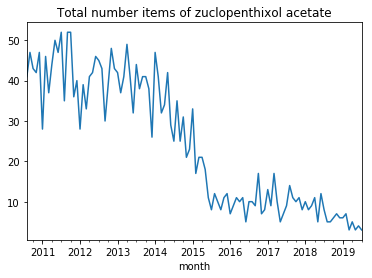

In [9]:
df_acetate.groupby("month")['acetate'].sum().plot(kind='line', title="Total number items of zuclopenthixol acetate")

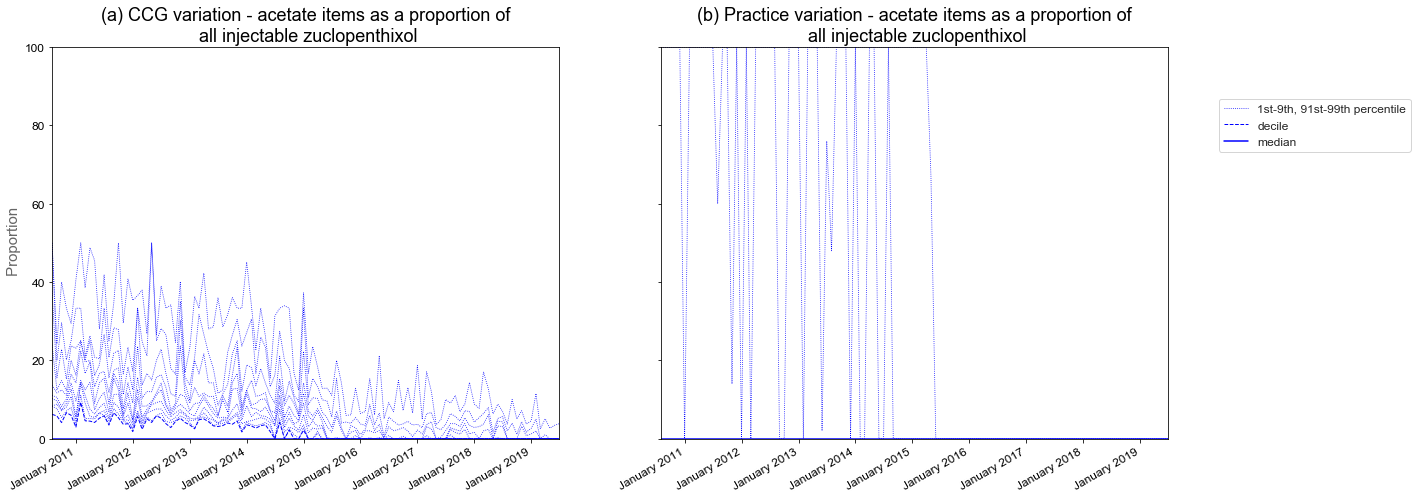

In [10]:
f = plt.figure(figsize=(20,8))
#f.suptitle('Sharing Y axis')
f.autofmt_xdate()
layout = gridspec.GridSpec(1, 2, figure=f)
left_plot = plt.subplot(layout[0])
right_plot = plt.subplot(layout[1], sharey=left_plot)  # Share the Y axis 

# ...and because it's shared, suppress ticks on the second chart
plt.setp(right_plot.get_yticklabels(), visible=False)

charts.deciles_chart(
    ccg_acetate_measure,
    period_column='month',
    column='measure_value',
    title=" (a) CCG variation - acetate items as a proportion of \n all injectable zuclopenthixol",
    ylabel=" Proportion",
    show_outer_percentiles=True,
    show_legend=False,
    ax=left_plot, 
) 


charts.deciles_chart(
    df_acetate_measure,
    period_column='month',
    column='measure_value',
    title=" (b) Practice variation - acetate items as a proportion of \n all injectable zuclopenthixol",
    ylabel="",
    show_outer_percentiles=True,
    show_legend=True,
    ax=right_plot,
) 

plt.ylim(0, 100)
plt.show()

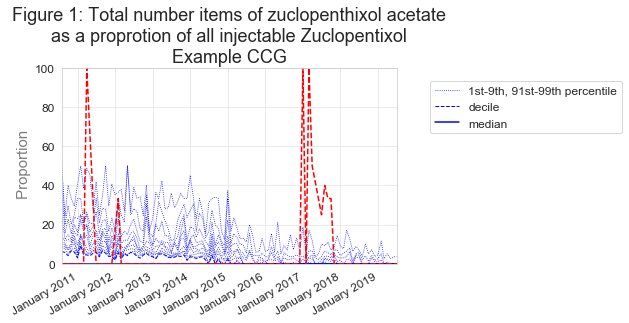

In [11]:
charts.deciles_chart(
    ccg_acetate_measure,
    period_column='month',
    column='measure_value',
    title=" Figure 1: Total number items of zuclopenthixol acetate \n as a proprotion of all injectable Zuclopentixol \n Example CCG ",
    ylabel=" Proportion",
    show_outer_percentiles=True,
    show_legend=True,
 
) 

df_subject = ccg_acetate_measure.loc[ccg_acetate_measure['pct'] == '09A'].sort_values(by=['month'])
plt.plot(df_subject['month'], df_subject['measure_value'], 'r--')

plt.ylim(0, 100)
plt.show()